In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import numpy as np 
import os
import time
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
DATASET_PATH='/content/drive/MyDrive/Colab Notebooks/preprocesd_cicids.csv'
print(DATASET_PATH)

/content/drive/MyDrive/Colab Notebooks/preprocesd_cicids.csv


In [18]:
# ,nrows=10000, header=0
start = time.time()
df=pd.read_csv(DATASET_PATH)
df.head()
print("Time taken to load the data: ", time.time()-start," seconds")

Time taken to load the data:  36.8602135181427  seconds


In [35]:
df.to_feather('output.feather')

In [36]:
import pyarrow.feather as feather

# Read the Feather file into a pandas DataFrame
start = time.time()
df = feather.read_feather('/content/output.feather')
print("Time taken to load the data: ", time.time()-start," seconds")
# Display the DataFrame
df.head()

Time taken to load the data:  2.7159292697906494  seconds


,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Flow Packets/s,...,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Init_Win_bytes_forward,Init_Win_bytes_backward,Active Mean,Active Std,Active Max,Idle Std,Label
0,54865,3,2,12,6,6,0,0,4000000.00,666666.700,...,0,0,0,33,-1,0.0,0.0,0,0.0,BENIGN
1,55054,109,1,6,6,6,6,6,110091.74,18348.623,...,0,0,0,29,256,0.0,0.0,0,0.0,BENIGN
2,55055,52,1,6,6,6,6,6,230769.23,38461.540,...,0,0,0,29,256,0.0,0.0,0,0.0,BENIGN
3,46236,34,1,6,6,6,6,6,352941.20,58823.530,...,0,0,0,31,329,0.0,0.0,0,0.0,BENIGN
4,54863,3,2,12,6,6,0,0,4000000.00,666666.700,...,0,0,0,32,-1,0.0,0.0,0,0.0,BENIGN


In [37]:
df.shape

(2520798, 44)

In [38]:
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr(numeric_only=True)
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
              colname = corr_matrix.columns[i]                  
              col_corr.add(colname)
    return col_corr

In [39]:
corr_features = correlation(df, 0.85)
corr_features

set()

In [40]:
df.drop(corr_features,axis=1,inplace=True)

In [41]:
df.shape

(2520798, 44)

In [42]:
# create a Series with the count of rows in each group
label_counts = df[' Label'].value_counts()

# create a list of labels that have less than 10,000 rows
labels_to_merge = label_counts[label_counts < 10000].index.tolist()
print(labels_to_merge)

[]


In [43]:
# create a new label called 'Other' and merge the labels with less than 10,000 rows
df[' Label'] = df[' Label'].apply(lambda x: 'Other' if x in labels_to_merge else x)
# group the rows by the new 'Label' column
grouped_df = df.groupby(' Label')

In [44]:
df.shape

(2520798, 44)

In [45]:
df[' Label'].value_counts()

BENIGN           2095057
DoS Hulk          172846
DDoS              128014
PortScan           90694
Other              23901
DoS GoldenEye      10286
Name:  Label, dtype: int64

In [46]:
x = df.drop([' Label'],axis=1)
y = df[' Label']

In [47]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
rus.fit(x, y)
Xn, yn = rus.fit_resample(x, y)
# Xn.value_counts()

In [48]:
Xn.shape

(61716, 43)

In [49]:
yn.shape

(61716,)

In [50]:
yn.value_counts()

BENIGN           10286
DDoS             10286
DoS GoldenEye    10286
DoS Hulk         10286
Other            10286
PortScan         10286
Name:  Label, dtype: int64

In [52]:
#z-score   z = (x - mean) / std   
# it can make it easier for the algorithm to learn meaningful patterns in the data
cols = list(Xn.columns)
for col in cols:
    Xn[col] = stats.zscore(Xn[col])

In [53]:
Xn.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Flow Packets/s,...,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Init_Win_bytes_forward,Init_Win_bytes_backward,Active Mean,Active Std,Active Max,Idle Std
0,-0.297014,-0.679777,-0.044940,-0.040850,-0.317990,0.490016,-0.713935,2.190765,-0.038518,-0.190288,...,NaN,NaN,NaN,NaN,-0.848314,-0.194997,-0.227431,-0.131538,-0.233081,-0.200218
1,4.852138,-0.681388,-0.109562,-0.054611,-0.379522,-0.126985,-0.741997,-0.254225,-0.039055,0.008263,...,NaN,NaN,NaN,NaN,-0.784403,-0.153281,-0.227431,-0.131538,-0.233081,-0.200218
2,-0.294582,2.295346,0.213547,-0.002414,0.375840,-0.126985,-0.639404,-0.254225,-0.039054,-0.191104,...,NaN,NaN,NaN,NaN,-0.270364,0.664176,-0.189442,-0.085769,-0.139767,-0.198220
3,-0.261889,-0.535558,0.041222,-0.007515,0.078787,-0.126985,-0.301450,-0.254225,-0.038974,-0.191085,...,NaN,NaN,NaN,NaN,-0.270364,-0.173232,-0.007060,-0.131538,-0.054383,-0.200218
4,-0.297014,-0.680783,-0.109562,-0.048917,-0.277675,0.894258,-0.703374,3.110923,-0.038223,-0.190381,...,NaN,NaN,NaN,NaN,-0.848314,-0.194997,-0.227431,-0.131538,-0.233081,-0.200218


In [54]:
from sklearn.model_selection import  train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(Xn,yn,test_size=0.20,random_state=0)

In [55]:
print(np.any(np.isnan(X_train)))
print(np.all(np.isfinite(X_train)))

True
False


In [56]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Create an instance of SimpleImputer with 'mean' strategy to replace NaN values
imputer = SimpleImputer(strategy='mean')

# Fit the imputer to X_train and transform X_train and X_test with it
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Apply StandardScaler to X_train and X_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [74]:
from sklearn.neighbors import KNeighborsClassifier
# model training USING KNN (suppor vector machine)
start = time.time()
k = 10 # number of nearest neighbors to consider
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, Y_train)
print("Time taken to train model: ", time.time()-start," seconds")

Time taken to train model:  0.26372313499450684  seconds


In [75]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics


# performance metrics calculation of our model over training data set
start = time.time()
Predict_X =  knn.predict(X_train)
scores = cross_val_score(knn, X_train, Y_train, cv=7)
accuracy = metrics.accuracy_score(Y_train,Predict_X)
confusion_matrix = metrics.confusion_matrix(Y_train, Predict_X)
classification = metrics.classification_report(Y_train, Predict_X)
print("Time taken to for performance matric calculation: ", time.time()-start," seconds")

Time taken to for performance matric calculation:  38.641499042510986  seconds


In [76]:
print()
print('--------------------------- Results --------------------------------')
print()
print ("Cross Validation Mean Score:" "\n", scores.mean())
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification) 
print()


--------------------------- Results --------------------------------

Cross Validation Mean Score:
 0.9862877407769899

Model Accuracy:
 0.9882321963866159

Confusion matrix:
 [[7855    2   56   23  161  135]
 [  10 8209    5    3    0    0]
 [   3    0 8264    8    7    0]
 [  29    9   22 8213    0    2]
 [  58    0   18    3 8151    7]
 [   4    1    1    7    7 8099]]

Classification report:
                precision    recall  f1-score   support

       BENIGN       0.99      0.95      0.97      8232
         DDoS       1.00      1.00      1.00      8227
DoS GoldenEye       0.99      1.00      0.99      8282
     DoS Hulk       0.99      0.99      0.99      8275
        Other       0.98      0.99      0.98      8237
     PortScan       0.98      1.00      0.99      8119

     accuracy                           0.99     49372
    macro avg       0.99      0.99      0.99     49372
 weighted avg       0.99      0.99      0.99     49372




In [77]:
def plot_confusion_matrix(cm,title,cmap=None,target=None,normalize=False):

    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('viridis')
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target is not None:
        ticks = np.arange(len(target))
        plt.xticks(ticks, target, rotation=45)
        plt.yticks(ticks, target)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title, bbox_inches='tight', dpi=300)

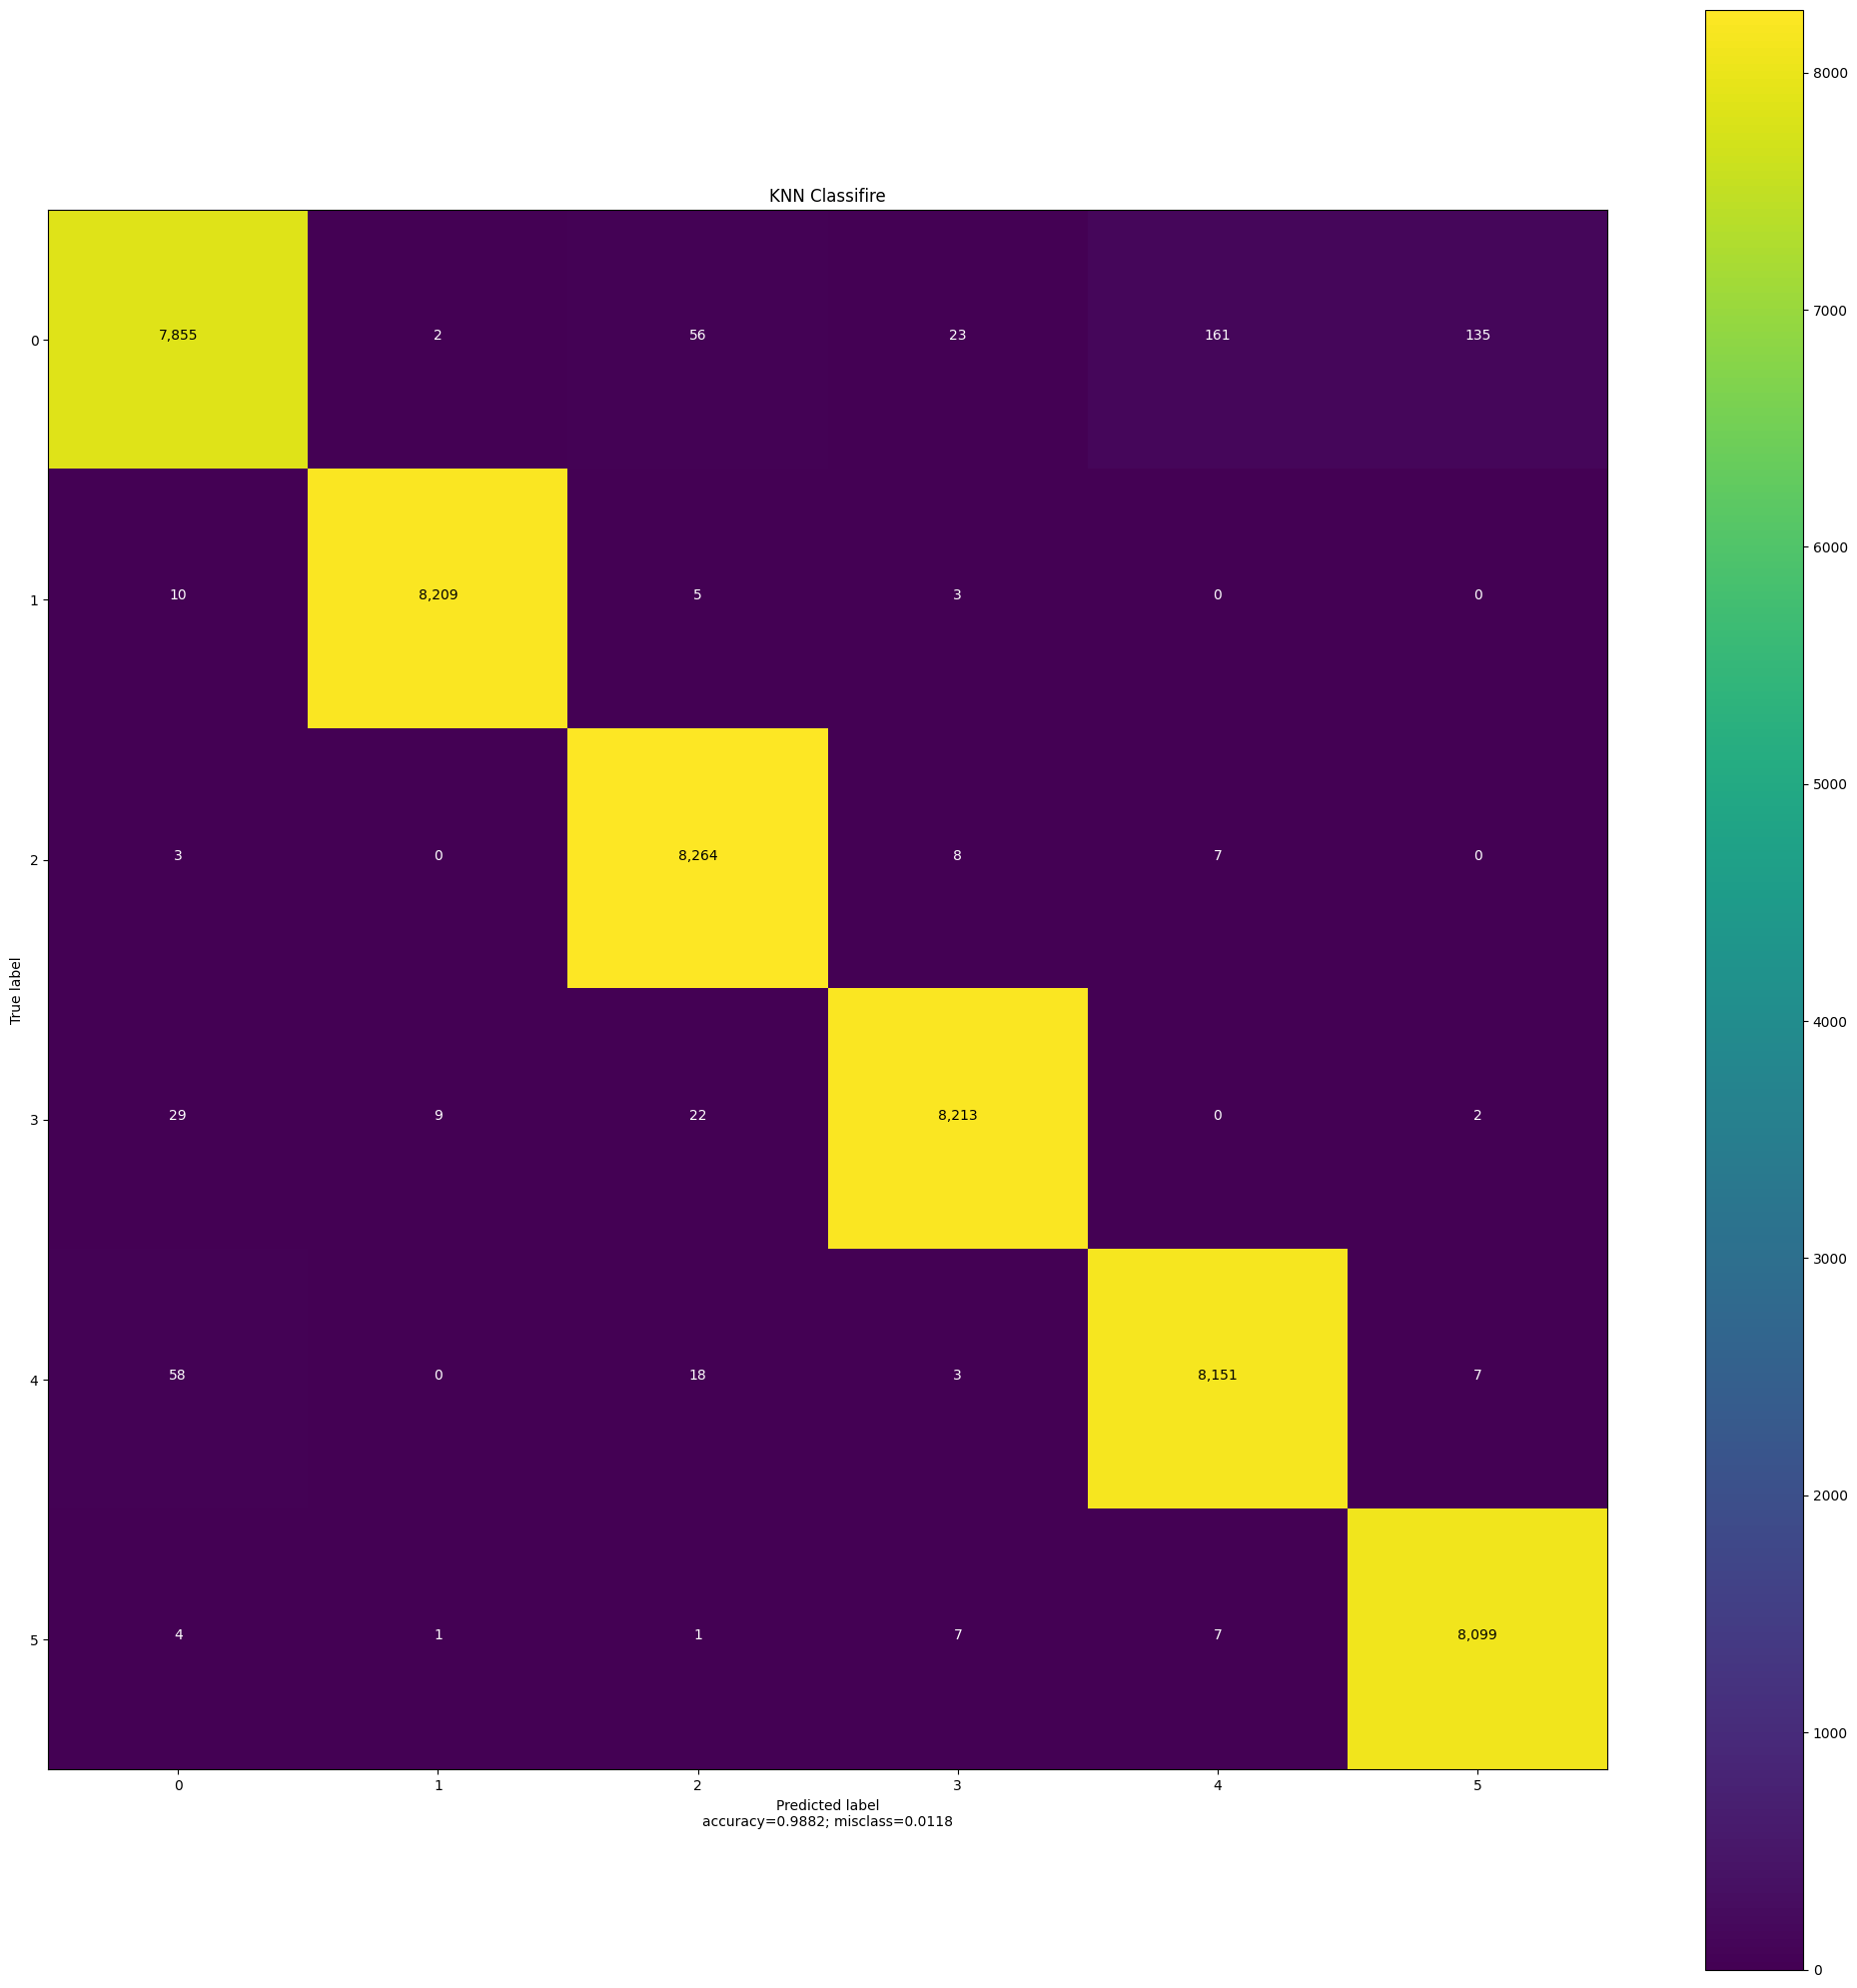

<Figure size 640x480 with 0 Axes>

In [78]:
plot_confusion_matrix(cm=confusion_matrix ,title= 'KNN Classifire')

In [79]:
# performance metrics calculation of our model over test data set
start = time.time()
Predict_X =  knn.predict(X_test)
scores = cross_val_score(knn, X_test, Y_test, cv=7)
accuracy = metrics.accuracy_score(Y_test,Predict_X)
confusion_matrix = metrics.confusion_matrix(Y_test, Predict_X)
classification = metrics.classification_report(Y_test, Predict_X)
print("Time taken to for performance matric calculation: ", time.time()-start," seconds")

Time taken to for performance matric calculation:  6.714439392089844  seconds


In [80]:
print()
print('--------------------------- Results --------------------------------')
print()
print ("Cross Validation Mean Score:" "\n", scores.mean())
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification) 
print()


--------------------------- Results --------------------------------

Cross Validation Mean Score:
 0.9797473752756377

Model Accuracy:
 0.9883344134802333

Confusion matrix:
 [[1959    0    9    7   49   30]
 [   0 2058    0    1    0    0]
 [   0    0 2002    1    1    0]
 [   9    0    6 1996    0    0]
 [  21    0    7    0 2020    1]
 [   1    0    0    0    1 2165]]

Classification report:
                precision    recall  f1-score   support

       BENIGN       0.98      0.95      0.97      2054
         DDoS       1.00      1.00      1.00      2059
DoS GoldenEye       0.99      1.00      0.99      2004
     DoS Hulk       1.00      0.99      0.99      2011
        Other       0.98      0.99      0.98      2049
     PortScan       0.99      1.00      0.99      2167

     accuracy                           0.99     12344
    macro avg       0.99      0.99      0.99     12344
 weighted avg       0.99      0.99      0.99     12344




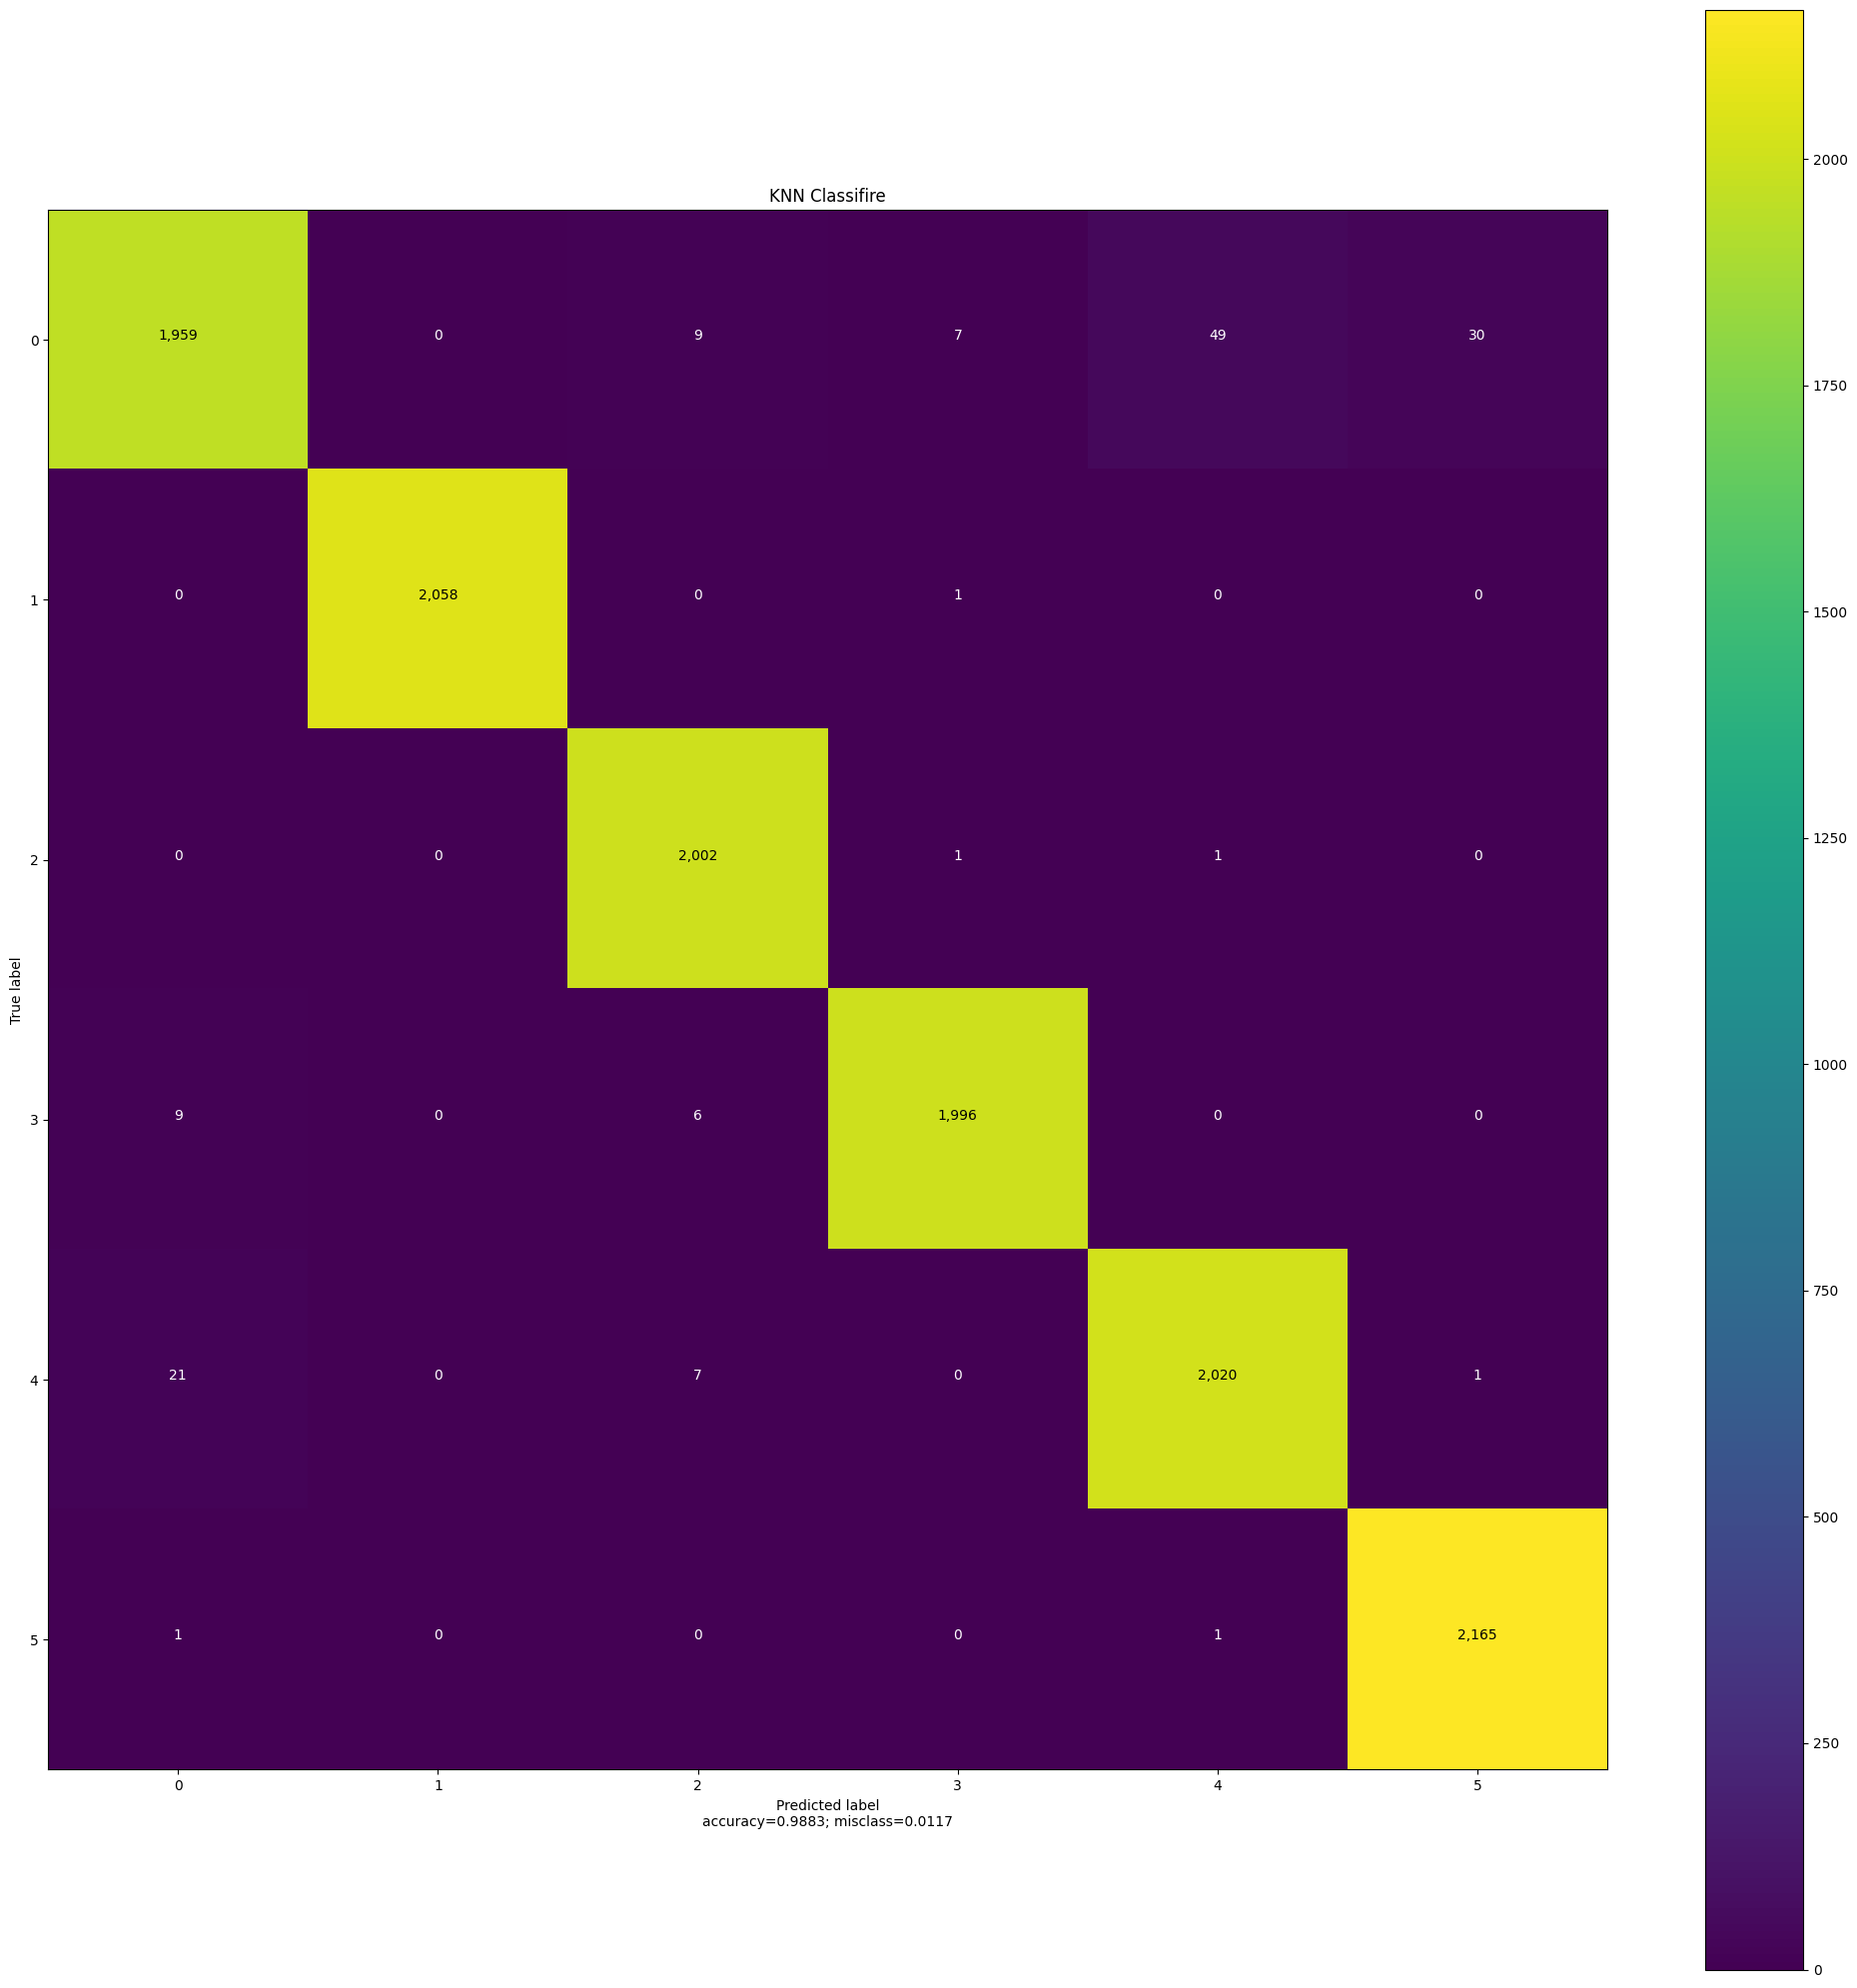

<Figure size 640x480 with 0 Axes>

In [81]:
plot_confusion_matrix(cm=confusion_matrix ,title= 'KNN Classifire')